In [ ]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, imaging, light
import matplotlib.pyplot as plt

# for reproducibility
rng = np.random.default_rng(92)
np.random.seed(92)

cleo.utilities.style_plots_for_docs()

In [ ]:
ng = b2.NeuronGroup(
    100,
    """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
    Iopto : amp""",
    threshold="v > -50*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "E_L": -70 * b2.mV,
    },
)
ng.v = -70 * b2.mV
cleo.coords.assign_coords_rand_rect_prism(
    ng, [-75, 75], [-75, 75], [50, 150], unit=b2.um
)
sim = cleo.CLSimulator(b2.Network(ng))

In [9]:
# variable expression
# rho_rel_gen = lambda n: rng.lognormal(0, 0.2, size=n)
# reuse same sample to have same expression for both GECIs
rho_rel = rng.lognormal(0, 0.2, size=100)
rho_rel_gen = lambda n: rho_rel[:n]

scopes = []

for i, geci in enumerate(
    [
        imaging.gcamp6f(doub_exp_conv=False),
        imaging.jgcamp7f(doub_exp_conv=False),
        imaging.ogb_1(doub_exp_conv=False),
    ]
):
    scope = imaging.Scope(
        focus_depth=100 * b2.um,
        img_width=150 * b2.um,
        sensor=geci,
        name=f"{geci} Scope",
    )
    sim.inject(scope, ng, rho_rel_generator=rho_rel_gen)
    scope.inject_sensor_for_targets()
    scopes.append(scope)
    i_targets = scope.i_targets_for_neuron_group(ng)
    print(scope.n)

TypeError: _create_s2f_geci_fn.<locals>.s2f_geci_fn() got an unexpected keyword argument 'doub_exp_conv'

In [8]:
cleo.viz.plot(ng, colors=["#c500cc"], devices=[scope])

NameError: name 'scope' is not defined

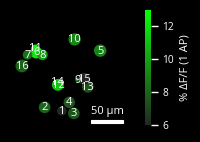

In [5]:
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.collections import EllipseCollection

with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(2.5, 1.5))
    x, y = ng.x[i_targets] / b2.um, ng.y[i_targets] / b2.um
    lim = scope.img_width * 1.2 / b2.um / 2
    ax.set(xlim=(-lim, lim), ylim=(-lim, lim), aspect="equal")

    perp_dist = np.abs(ng.z[i_targets] - scope.focus_depth)
    r_visible = np.sqrt(scope.soma_radius**2 - perp_dist**2)
    r_visible_um = r_visible / b2.um
    cmap = sns.dark_palette("xkcd:fluorescent green", as_cmap=True)
    rois = EllipseCollection(
        r_visible_um * 2,
        r_visible_um * 2,
        0,
        units="xy",
        offsets=np.c_[x, y],
        offset_transform=ax.transData,
        cmap=cmap,
    )
    rois.set_array(100 * scopes[0].dFF_1AP)
    ax.add_collection(rois)
    # easier, more accurate with EllipseCollection
    # r_visible_pt = r_visible / scope.img_width * ax.bbox.width
    # markerarea = np.pi * r_visible_pt**2
    # rois = ax.scatter(x, y, s=markerarea, c=scope.dFF_1AP, cmap=cmap)

    scale_um = 50
    ax.add_artist(
        AnchoredSizeBar(
            ax.transData,
            scale_um,
            f"{scale_um} µm",
            "lower right",
            frameon=False,
            color="w",
            label_top=True,
            size_vertical=scale_um / 10,
        )
    )
    ax.set_axis_off()
    # annotate each neuron with its index
    for i_img, (x_, y_) in enumerate(zip(x, y)):
        ax.annotate(
            i_img + 1,
            (x_, y_),
            # (x_ + 15, y_),
            color="w",
            ha="center",
            va="center",
            annotation_clip=False,
            fontsize=8,
        )

    cbar = fig.colorbar(rois, label="% ΔF/F (1 AP)", drawedges=False, pad=0.1)
    cbar.outline.set_visible(False)

In [6]:
sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period=1*b2.ms))

CLSimulator(io_processor=RecordOnlyProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={GECI(name='jGCaMP7f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\nCaB_active = Ca: mmolar\nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_baseline\n            ) : 1\n            rho_rel : 1\n        ', on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', sigma_noise=0.021763636363636363, dFF_1AP=0.22743000000000002, location='cytoplasm', cal_model=DynamicCalcium(on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1', Ca_re

In [7]:
sim.run(1*b2.second)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_GCaMP6f_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_OGB_1_neurongroup', using method 'euler' (took 0.00s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_jGCaMP7f_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


In [ ]:
fig, ax = plt.subplots()

for scope in scopes:
    i_all_targets = scope.i_targets_for_neuron_group()